In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Let's get started by importing Bitcoin and Ether data:

In [3]:
df = pd.read_csv(
    'data/btc-eth-prices-outliers.csv',
    index_col=0,
    parse_dates=True
)

In [5]:
df.head()

,Bitcoin,Ether
Timestamp,,
2017-04-02,1099.169125,48.55
2017-04-03,1141.813000,44.13
2017-04-04,1141.600363,44.43
2017-04-05,1133.079314,44.90
2017-04-06,1196.307937,43.23


And now we can run a simple visualization:

<AxesSubplot:xlabel='Timestamp'>

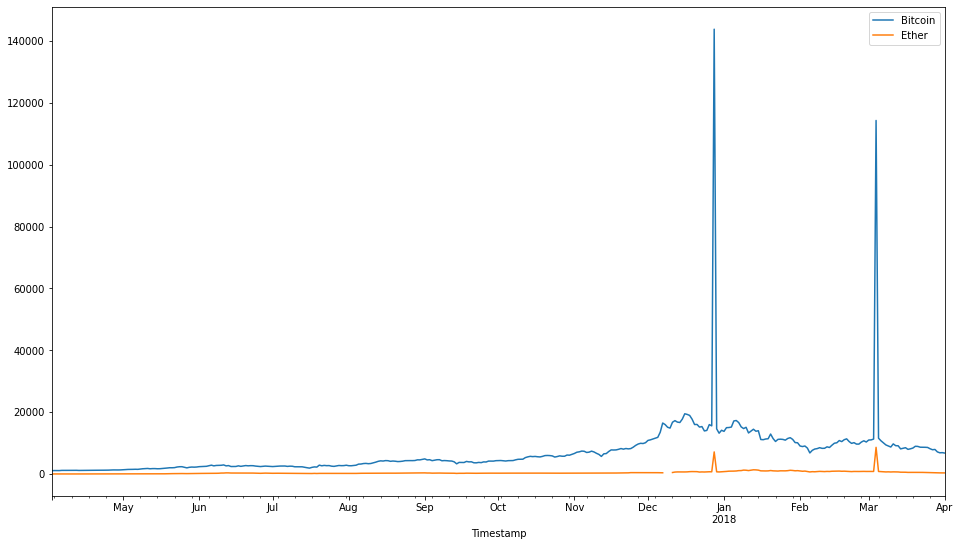

In [6]:
df.plot(figsize=(16, 9))

There are clearly some invalid values, both ETH and BTC have huge spikes. On top of that, there seems to be some data missing in Ether between December 2017 and and January 2018:

<AxesSubplot:xlabel='Timestamp'>

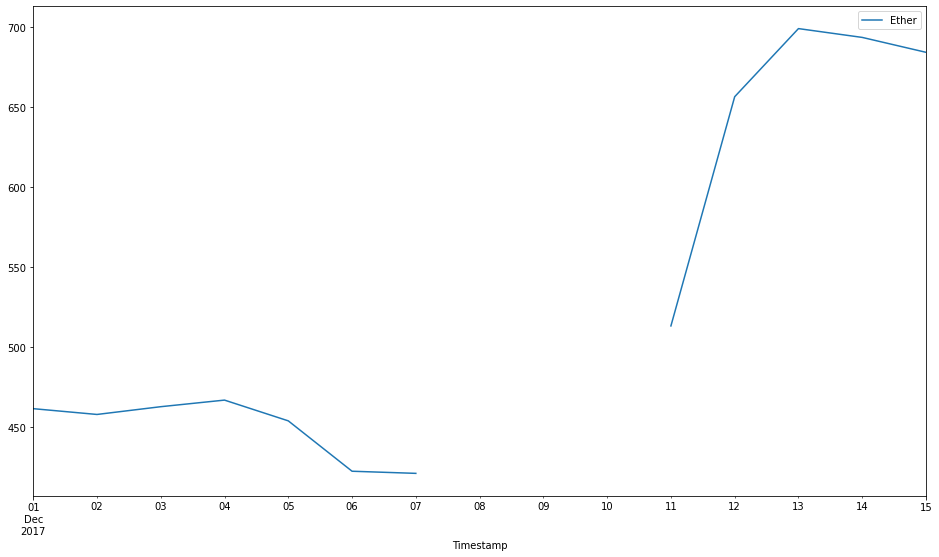

In [7]:
df.loc['2017-12': '2017-12-15'].plot(y='Ether', figsize=(16, 9))

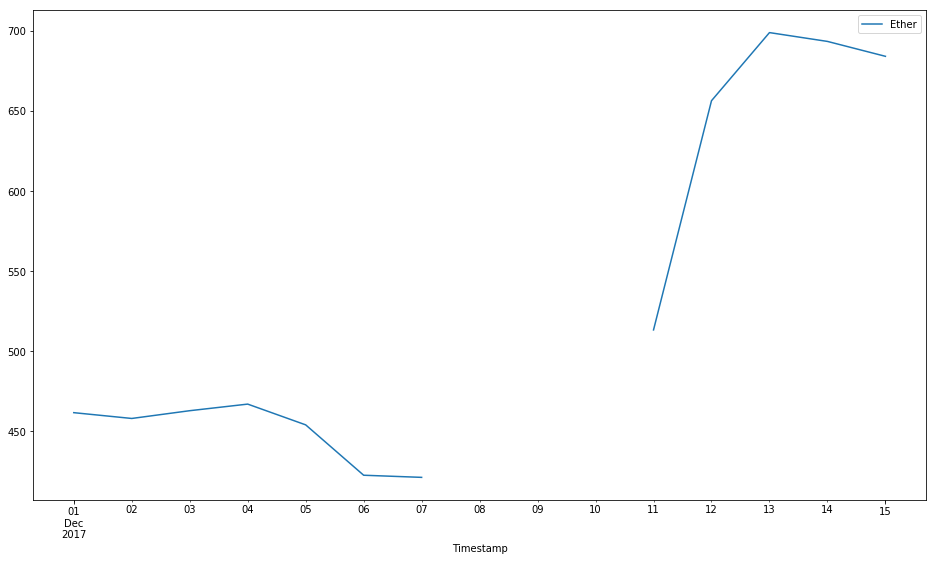

In [6]:
df.loc['2017-12': '2017-12-15'].plot(y='Ether', figsize=(16, 9))

In [8]:
df_na = df.loc['2017-12': '2017-12-15']

Are those null values?

In [9]:
df_na['Ether'].isnull().values.any()

True

When? what periods of time?

In [10]:
df_na.loc[df_na['Ether'].isnull()]

,Bitcoin,Ether
Timestamp,,
2017-12-08,16007.436667,NaN
2017-12-09,15142.834152,NaN
2017-12-10,14869.805000,NaN


Let's add a little bit more context:

In [10]:
df.loc['2017-12-06': '2017-12-12']

,Bitcoin,Ether
Timestamp,,
2017-12-06,13540.980000,422.48
2017-12-07,16501.971667,421.15
2017-12-08,16007.436667,NaN
2017-12-09,15142.834152,NaN
2017-12-10,14869.805000,NaN
2017-12-11,16762.116667,513.29
2017-12-12,17276.393333,656.52


We now need to decide what we'll do with the missing values. Drop them? fill them? If we decide to fill them, what will be use as fill value? For example: we can use the previous value and just assume the price stayed the same.

In [11]:
df.loc['2017-12-06': '2017-12-12'].fillna(method='bfill')

,Bitcoin,Ether
Timestamp,,
2017-12-06,13540.980000,422.48
2017-12-07,16501.971667,421.15
2017-12-08,16007.436667,513.29
2017-12-09,15142.834152,513.29
2017-12-10,14869.805000,513.29
2017-12-11,16762.116667,513.29
2017-12-12,17276.393333,656.52


In [11]:
df.fillna(method='bfill', inplace=True) #inplace is for keeping the changes

Let's take a look now:

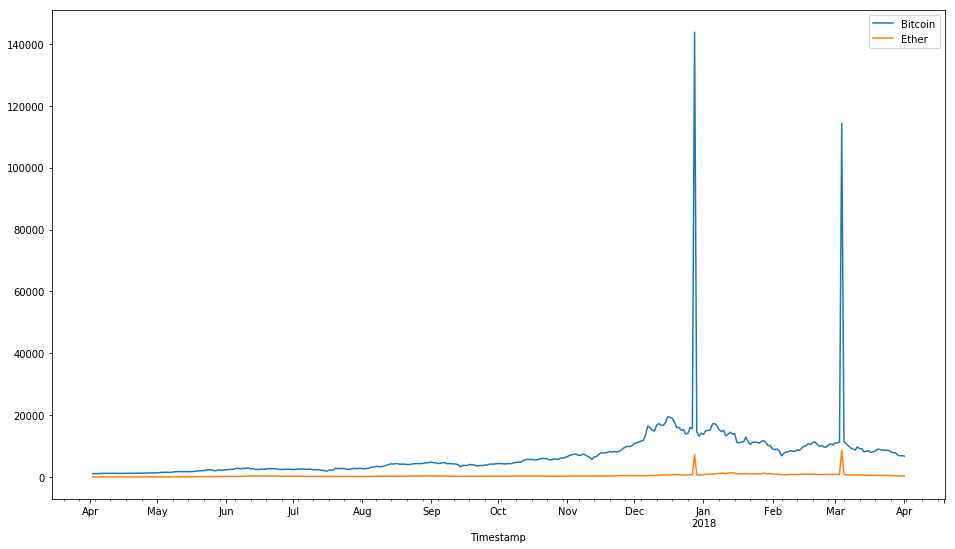

In [13]:
df.plot(figsize=(16, 9))

Much better. We now need to fix the huge spikes. The first step is identifying them. How can we do it? The simple answer is of course visually. They seem to be located in the last 10 days of Dec 2017 and first of March 2018:

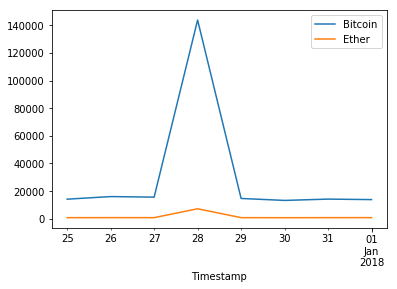

In [14]:
df['2017-12-25':'2018-01-01'].plot()

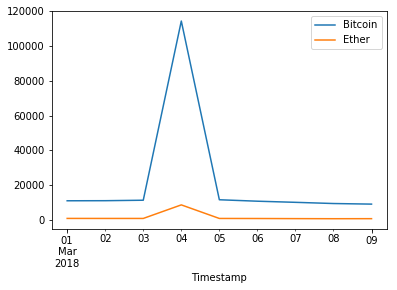

In [15]:
df['2018-03-01': '2018-03-09'].plot()

Apparently, they're located in '2017-12-28' and '2018-03-04':

In [12]:
df_cleaned = df.drop(pd.to_datetime(['2017-12-28', '2018-03-04']))

<AxesSubplot:xlabel='Timestamp'>

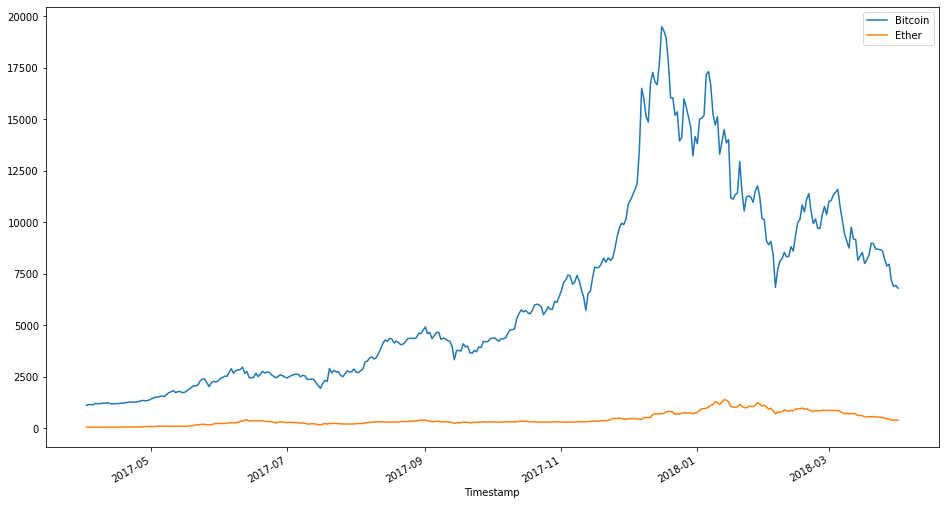

In [13]:
df_cleaned.plot(figsize=(16, 9))

Now it looks much better. Our data seems to be clean.

## Cleaning Analysis 

Visualizations helps make sense of the data and let us judge if our analysis and work is on the right track. But we need a more powerful method to handle our data. That's what we call "analysis". We'll use _analytical_ methods to identify these outliers or these skewed values.

### Central Tendency

We'll use a set of common indicators of to measure central tendency and identify these outliers:

##### mean
The mean is probably the most common and popular one. The problem is that it's really sensitive to outliers. The mean of our dataset with invalid values is:

In [18]:
df.mean()

Bitcoin    6996.004022
Ether       469.609068
dtype: float64

Both values seem too high. That's because the outliers are skewing with the mean:

In [19]:
df_cleaned.mean()

Bitcoin    6323.509186
Ether       428.628402
dtype: float64

##### median

In [20]:
df.median()

Bitcoin    4594.98785
Ether       309.49000
dtype: float64

In [14]:
df_cleaned.median()

Bitcoin    4580.38748
Ether       309.32000
dtype: float64

##### mode

It doesn't make much sense to measure the mode, as we have continuous values. But you can do it just with `df.mode()`.

### Visualizing distribution

Now we can use a few of the charts that we saw before + seaborn to visualize the distribution of our values. In particular, we're interested in **histograms**:

<AxesSubplot:ylabel='Frequency'>

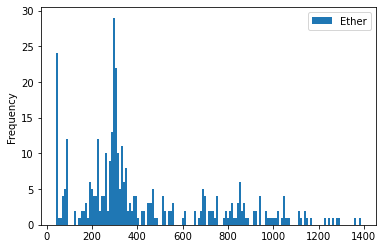

In [15]:
df_cleaned.plot(kind='hist', y='Ether', bins=150)

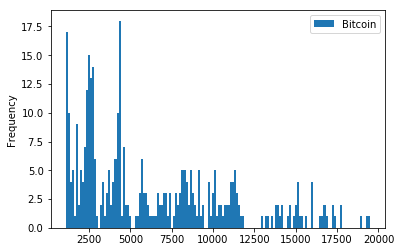

In [37]:
df_cleaned.plot(kind='hist', y='Bitcoin', bins=150)

Using seaborn:

c:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Ether', ylabel='Density'>

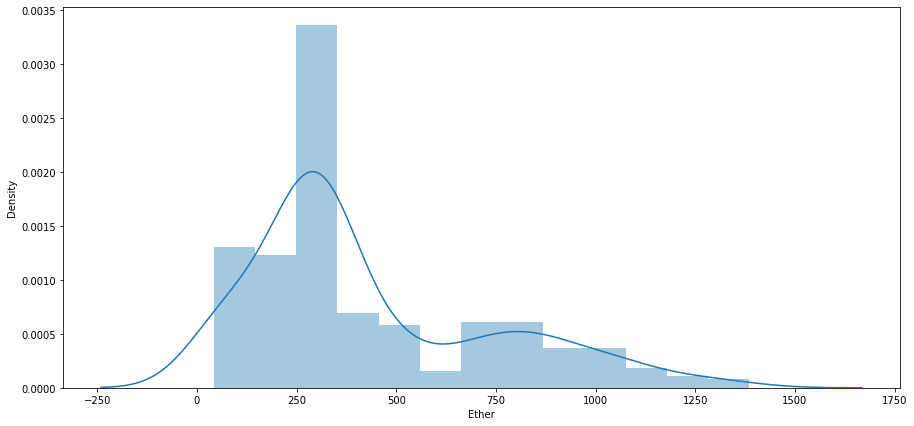

In [18]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.distplot(df_cleaned['Ether'], ax=ax)

c:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Bitcoin', ylabel='Density'>

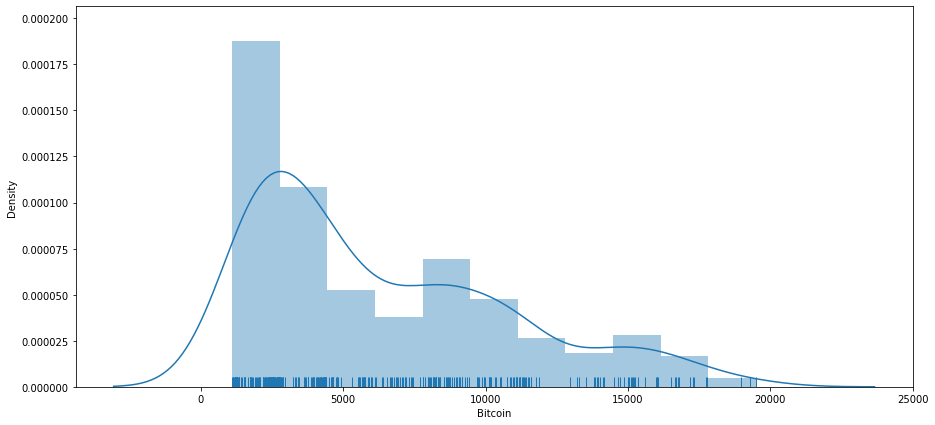

In [19]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.distplot(df_cleaned['Bitcoin'], rug=True, ax=ax)

Seaborn's `distplot` is a general method that will plot a histogram, a KDE and a rugplot. You can also use them as separate:

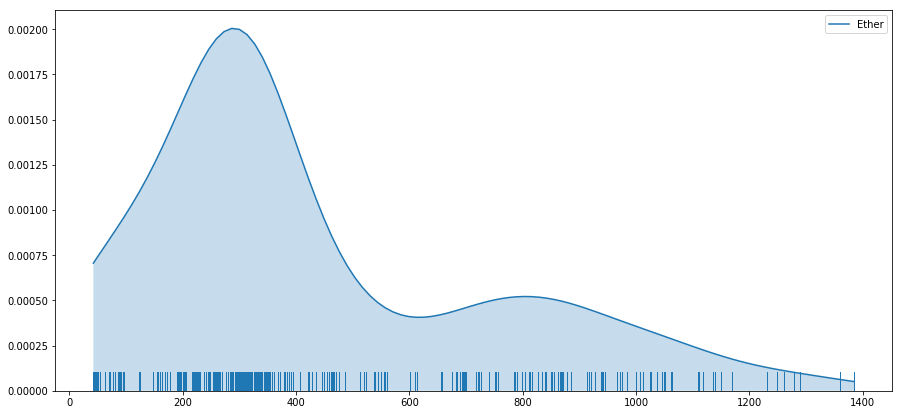

In [38]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.kdeplot(df_cleaned['Ether'], shade=True, cut=0, ax=ax)
sns.rugplot(df_cleaned['Ether'], ax=ax);

We can also visualize a cumulative plot of our distribution:

/Users/santiagobasulto/.virtualenvs/ds-classes/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


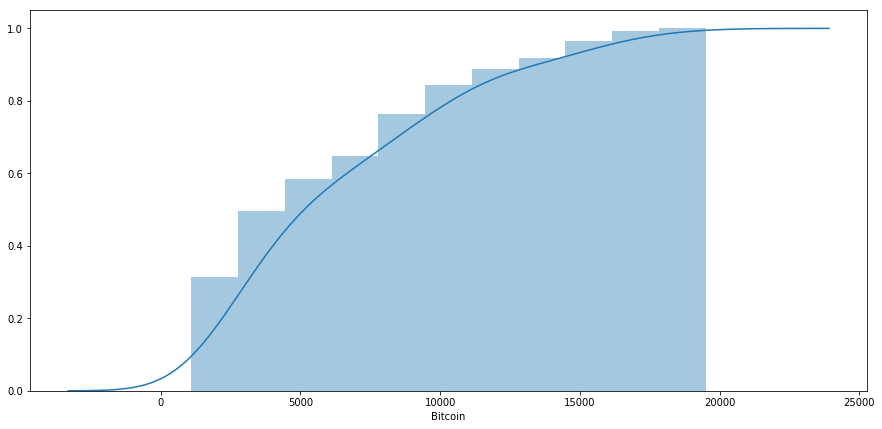

In [7]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.distplot(df_cleaned['Bitcoin'], ax=ax,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))


This plot shows how many samples fall behind a certain value. We can increase the number of bins in order to have more detail:

/Users/santiagobasulto/.virtualenvs/ds-classes/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


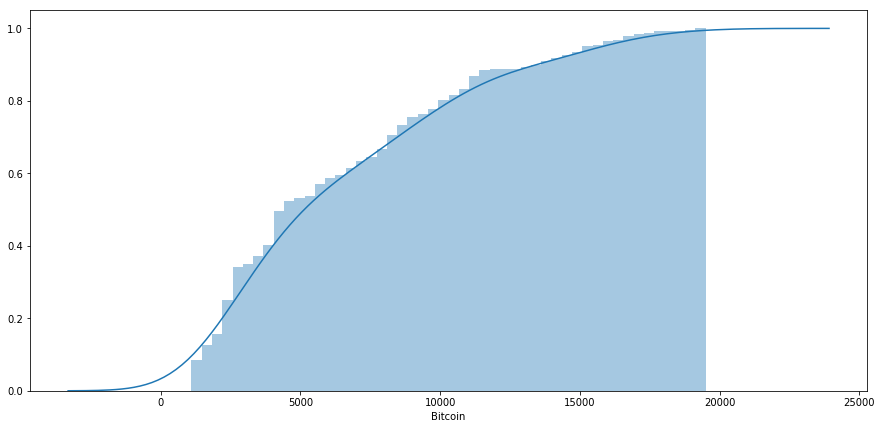

In [12]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.distplot(df_cleaned['Bitcoin'], ax=ax, bins=50,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))


### Visualizing bivariate distributions

The most common way to observe a bivariate distribution is a scatterplot, the `jointplot` will also include the distribution of the variables:

/Users/santiagobasulto/.virtualenvs/ds-classes/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


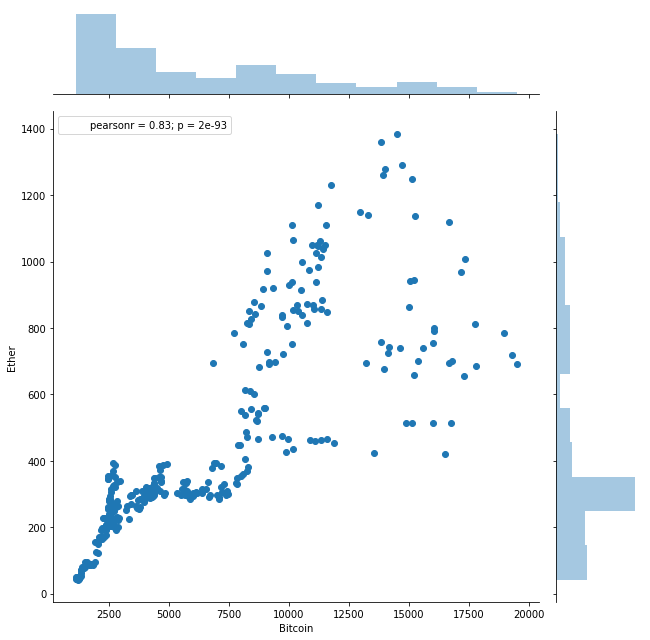

In [43]:
sns.jointplot(x="Bitcoin", y="Ether", data=df_cleaned, size=9)

If you want only a scatter plot, you can use the `regplot` method, that also fits a linear regression model in the plot:

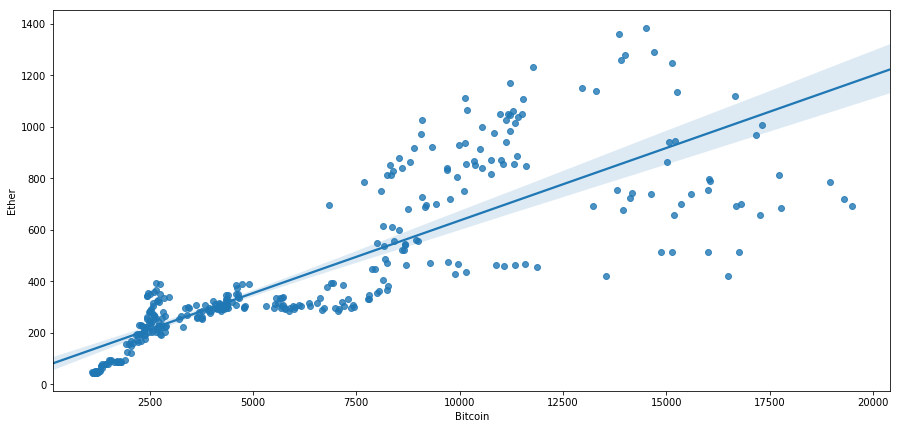

In [45]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.regplot(x="Bitcoin", y="Ether", data=df_cleaned, ax=ax)

### Quantiles, quartiles and percentiles

In [20]:
df_cleaned['Bitcoin'].quantile(.2) #20% of the total sum.

2438.8627342857144

/Users/santiagobasulto/.virtualenvs/ds-classes/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


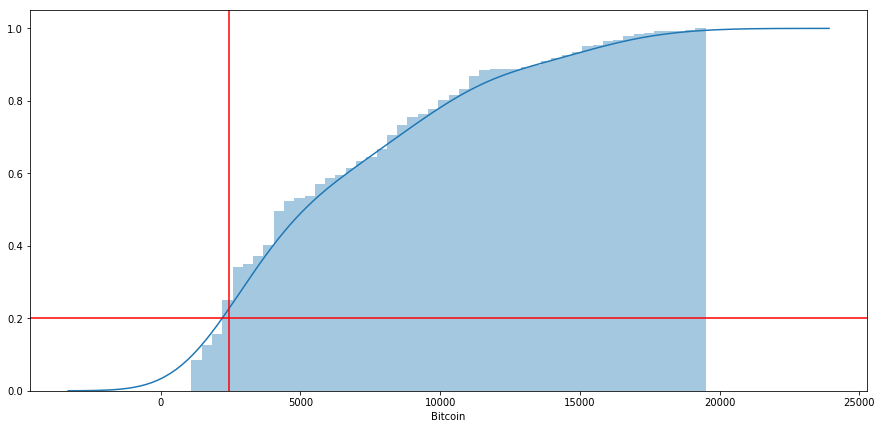

In [13]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.distplot(df_cleaned['Bitcoin'], ax=ax, bins=50,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
ax.axhline(0.2, color='red')
ax.axvline(df_cleaned['Bitcoin'].quantile(.2), color='red')

In [21]:
df_cleaned['Bitcoin'].quantile(.5)

4580.387479999999

In [20]:
df_cleaned['Bitcoin'].median()

4580.3874799999985

/Users/santiagobasulto/.virtualenvs/ds-classes/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


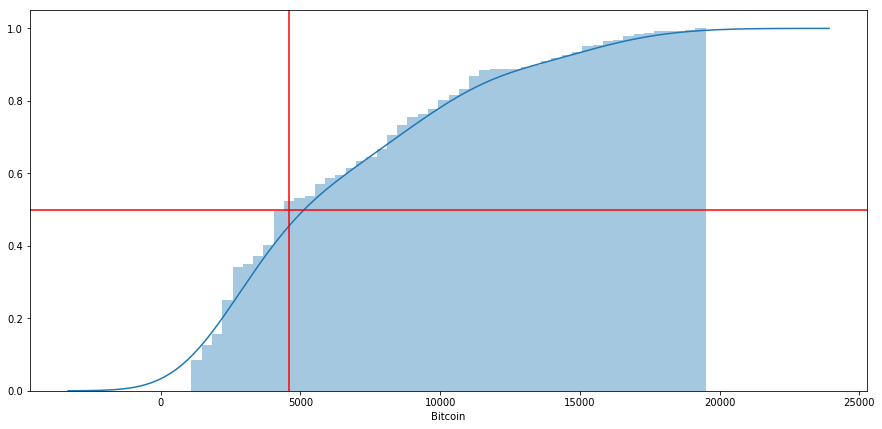

In [18]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.distplot(df_cleaned['Bitcoin'], ax=ax, bins=50,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
ax.axhline(0.5, color='red')
ax.axvline(df_cleaned['Bitcoin'].quantile(.5), color='red')

/Users/santiagobasulto/.virtualenvs/ds-classes/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


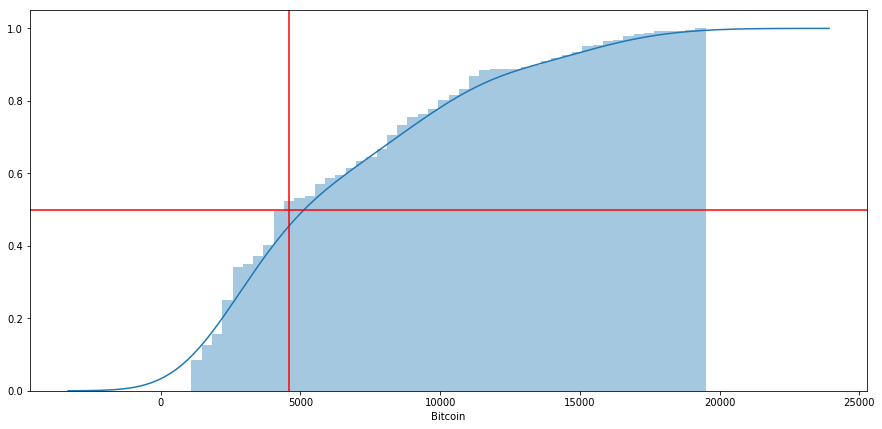

In [19]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.distplot(df_cleaned['Bitcoin'], ax=ax, bins=50,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
ax.axhline(0.5, color='red')
ax.axvline(df_cleaned['Bitcoin'].median(), color='red')

Quantile `0.25` == Percentile `25%` == Quartile `1st`

## Dispersion

We'll use a few methods to measure dispersion in our dataset, most of them well known:

* Range
* Variance and Standard Deviation
* IQR

##### Range

Range is fairly simple to understand, it's just the max - min values:

In [21]:
df['Bitcoin'].max() - df['Bitcoin'].min()

142706.6475416667

Range is **really** sensitive to outliers. As you can see, the range value is extremely high (might indicate the presence of outliers / invalid values).

In [22]:
df_cleaned['Bitcoin'].max() - df_cleaned['Bitcoin'].min()

18399.514208333334

This value now makes a lot more sense. We know that Bitcoin had a high in about 20k, and it was around 900 when we started measuring. It makes more sense now.

##### Variance and Standard Deviation

In [23]:
df['Bitcoin'].var()

103766537.75278121

In [24]:
df['Bitcoin'].std()

10186.586167739475

Both variance and std are sensible to outliers as well. We can check with our cleaned dataset:

In [26]:
df_cleaned['Bitcoin'].std()

4513.757662530282

### IQR

The [Interquartile range](https://en.wikipedia.org/wiki/Interquartile_range) is a good measure of "centered" dispersion, and is calculated as `Q3 - Q1` (3rd quartile - 1st quartile).

In [27]:
df['Bitcoin'].quantile(.75) - df['Bitcoin'].quantile(.25)

6597.494147619047

In [28]:
df_cleaned['Bitcoin'].quantile(.75) - df_cleaned['Bitcoin'].quantile(.25)

6548.249242559523

As you can see, IQR is more robust than std or range, because it's not so sensitive to outliers.

### Analytical Analysis of invalid values

We can now use the measurements we've seen to analyze those values that seem invalid.

##### Using `std`: Z scores

We can now define those values that are a couple of Z scores above or below the mean (or the max/min value). Example:

In [22]:
upper_limit = df['Bitcoin'].mean() + 2 * df['Bitcoin'].std()
lower_limit = df['Bitcoin'].mean() - 2 * df['Bitcoin'].std()

In [23]:
print("Upper Limit: {}".format(upper_limit))
print("Lower Limit: {}".format(lower_limit))

Upper Limit: 27369.17635730169
Lower Limit: -13377.16831365621


c:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


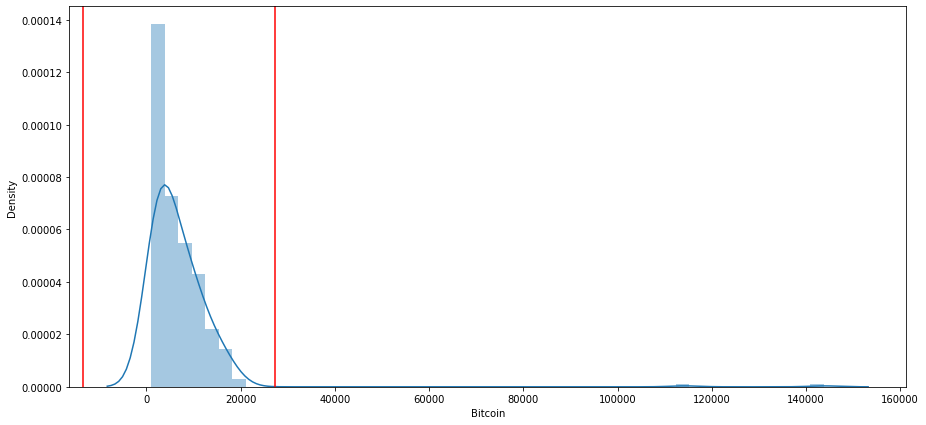

In [24]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.distplot(df['Bitcoin'], ax=ax)
ax.axvline(lower_limit, color='red')
ax.axvline(upper_limit, color='red')

Seems like this is a good measurement. Our lower limit doesn't make a lot of sense, as negative values are invalid. But our upper limit has a really good measure. Anything above \$27,369 is considered to be an invalid value. Pretty accurate.

##### Using IQRs

We can use the IQR instead of std if we think that the standard deviation might be **too** affected by the outliers/invalid values.

In [25]:
iqr = df['Bitcoin'].quantile(.75) - df['Bitcoin'].quantile(.25)
iqr

6597.494147619047

In [26]:
upper_limit = df['Bitcoin'].mean() + 2 * iqr
lower_limit = df['Bitcoin'].mean() - 2 * iqr

In [27]:
print("Upper Limit: {}".format(upper_limit))
print("Lower Limit: {}".format(lower_limit))

Upper Limit: 20190.992317060834
Lower Limit: -6198.9842734153535


c:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


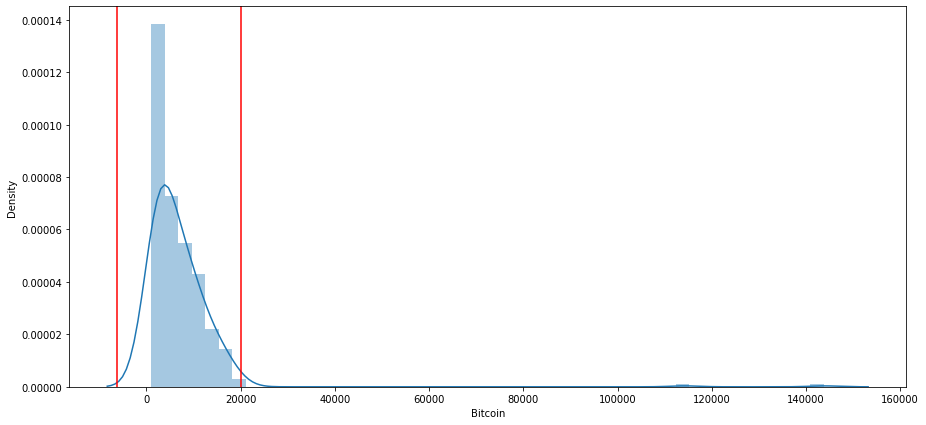

In [28]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.distplot(df['Bitcoin'], ax=ax)
ax.axvline(lower_limit, color='red')
ax.axvline(upper_limit, color='red')

Our measurement now is a little bit less precise. There are a few valid values (20k) that seem to be above our upper limit. Regardless, it's still a good indicator.

### Cleaning invalid values analytically

It's time now to remove these invalid values analytically, we'll use the upper limit defined by standard deviation:

In [29]:
upper_limit = df['Bitcoin'].mean() + 2 * df['Bitcoin'].std()

<AxesSubplot:xlabel='Timestamp'>

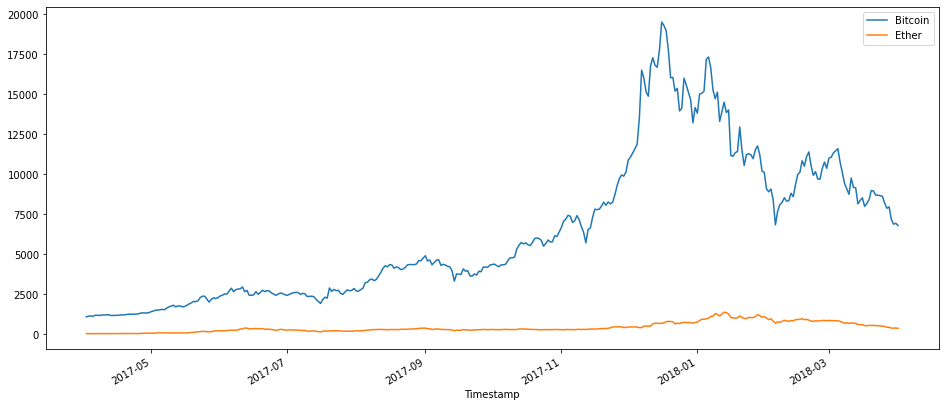

In [30]:
df[df['Bitcoin'] < upper_limit].plot(figsize=(16, 7))

<AxesSubplot:xlabel='Timestamp'>

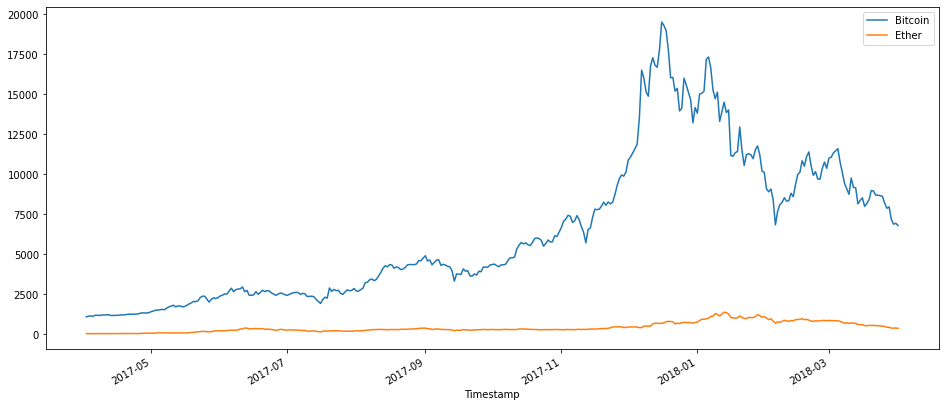

In [31]:
df.drop(df[df['Bitcoin'] > upper_limit].index).plot(figsize=(16, 7))